### Import needed libraries

In [68]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import cv2
import PIL
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

### Import dataset

In [69]:
# Set initial variables
mask_data_dir = "./data/trainvalidate/WithMask/"
nomask_data_dir = "./data/trainvalidate/WithoutMask/"
img_height = img_width = desired_size = 100
img_channels = 3
initialdata = []
labels = []
shapes = []

# Import images
for filename in os.listdir(mask_data_dir):
    img=cv2.imread(mask_data_dir+filename, cv2.IMREAD_UNCHANGED)
    b,g,r = cv2.split(img)       # get b, g, r
    img = cv2.merge([r,g,b])     # switch to r, g, b
    initialdata.append(img)
    labels.append(1)
    shapes.append(img.shape)
    
for filename in os.listdir(nomask_data_dir):
    img=cv2.imread(nomask_data_dir+filename, cv2.IMREAD_UNCHANGED)
    b,g,r = cv2.split(img)       # get b, g, r
    img = cv2.merge([r,g,b])     # switch to r, g, b
    initialdata.append(img)
    labels.append(0)
    shapes.append(img.shape)

print(f"The total number of images in the dataset is: {len(initialdata)}")

The total number of images in the dataset is: 6802


### Show sample images

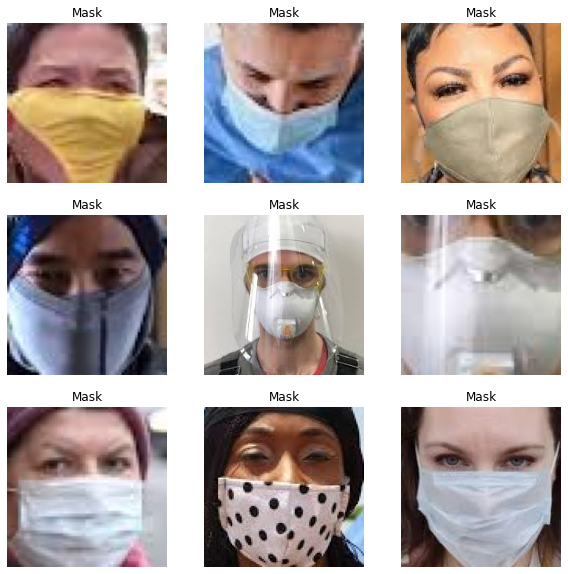

In [70]:
maskdict = ["No Mask", "Mask"]
plt.figure(figsize=(10, 10))
for i in range(10,19):
    ax = plt.subplot(3, 3, i + 1 -10)
    plt.imshow(initialdata[i].astype("uint8"))
    plt.title(maskdict[labels[i]])
    plt.axis("off")

### Check the shape of the images

The smallest height: 25
The smallest width: 25
The biggest height: 563
The biggest width: 563


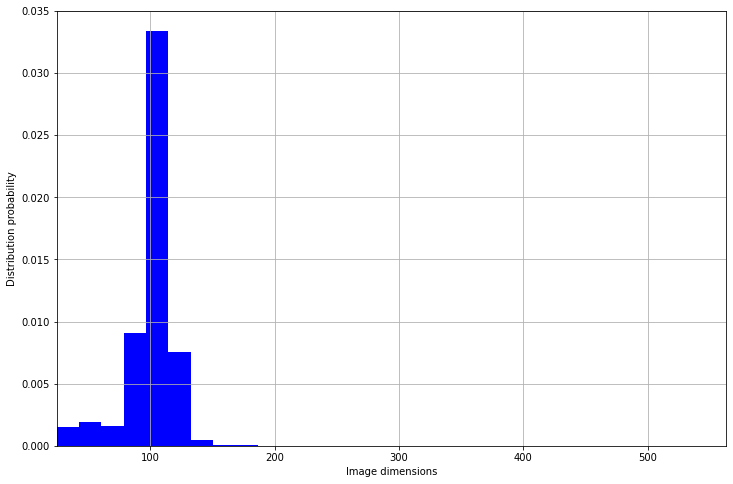

In [71]:
#Get smallest and biggest dimensions
smallestheight = biggestheight = shapes[0][0]
smallestwidth = biggestwidth = shapes[0][1]
for shape in shapes:
    if shape[0] < smallestheight:
        smallestheight = shape[0]
    if shape[0] > biggestheight:
        biggestheight = shape[0]
    if shape[1] < smallestwidth:
        smallestwidth = shape[1]
    if shape[1] > biggestwidth:
        biggestwidth = shape[1]

print(f"The smallest height: {smallestheight}")
print(f"The smallest width: {smallestwidth}")
print(f"The biggest height: {biggestheight}")
print(f"The biggest width: {biggestwidth}")
        
#Check if any images are not rectangular 
for shape in shapes:
    if shape[0] != shape[1]:
        print("Some images are not rectangular")
        break

#Extract one dimension from shape (doesnt matter which since images are rect), and then plot histogram
shapes_one_dimension = []
for shape in shapes:
    shapes_one_dimension.append(shape[0])

n, bins, patches = plt.hist(shapes_one_dimension, 30, density=1, facecolor='b')

plt.rcParams["figure.figsize"] = (12,8)
plt.xlabel('Image dimensions')
plt.ylabel('Distribution probability')
plt.axis([min(smallestheight, smallestwidth), max(biggestheight, biggestwidth), 0, 0.035])
plt.grid(True)
plt.show()

### Resize images , using 0 padding to maintain aspect ratio

In [72]:
# convert imported images into desired size
data = []
for im in initialdata:
    old_size = im.shape[:2]
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    new_im = cv2.resize(im, (new_size[1], new_size[0]), interpolation=cv2.INTER_CUBIC)

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(new_im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    data.append(new_im)

### Split dataset to Train, Validate, and Test sets

In [73]:
#Split data between train, validation, and test 
trainvalid_data, test_data, trainvalid_label, test_label = train_test_split(data, labels, test_size=0.05)
train_data, valid_data, train_label, valid_label = train_test_split(trainvalid_data, trainvalid_label, test_size=0.2)

#Convert lists back to numpy array
train_data = np.asarray(train_data)
valid_data = np.asarray(valid_data)
test_data = np.asarray(test_data)
train_label = np.asarray(train_label)
valid_label = np.asarray(valid_label)
test_label = np.asarray(test_label)

### Show count of each set then plot histogram

Dataset        Total Size     Without Mask   With Mask      
Total          6802           5909 (87.0%)   893 (13.0%)    
Training       5168           4470 (86.0%)   698 (14.000000000000002%)
Validation     1293           1138 (88.0%)   155 (12.0%)    
Test           341            301 (88.0%)    40 (12.0%)     


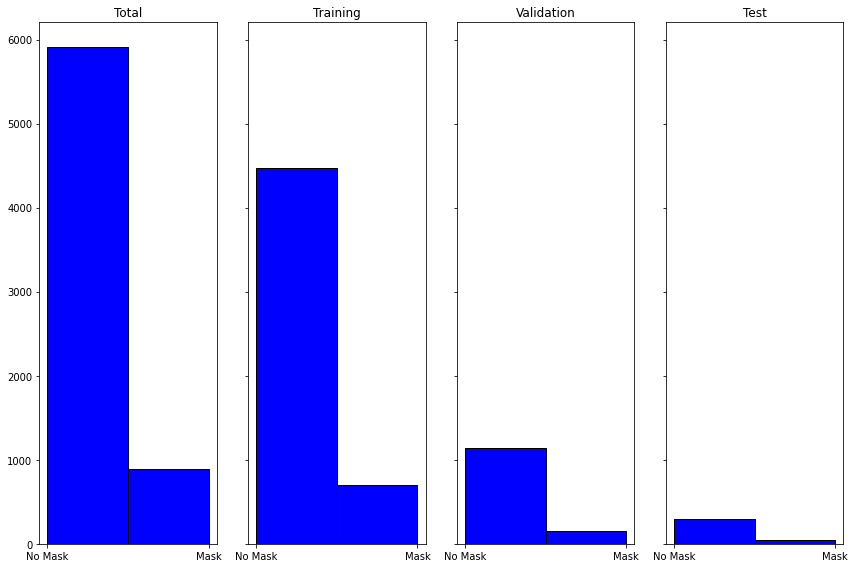

In [74]:
# Show table for count in each dataset
tableheader = ["Dataset", "Total Size", "Without Mask", "With Mask"]
tabledata = list()
format_row = "{:<15}" * (len(tableheader))
print(format_row.format(*tableheader))

labeldict = {"Total": labels, "Training": train_label, "Validation": valid_label, "Test": test_label}
for key in labeldict:
    total = len(labeldict[key])
    count_no_mask = count_with_mask = 0
    for label in labeldict[key]: 
        if label == 0: count_no_mask+=1
    count_with_mask = total-count_no_mask
    tabledata.append((str(key), str(total), str(count_no_mask) + " (" + str(round(count_no_mask/total, 2)*100) +"%)", str(count_with_mask) + " (" + str(round(count_with_mask/total, 2)*100) +"%)"))
    
for row in tabledata:
    print(format_row.format(*row))

# Plot the histogram
fig, axs = plt.subplots(1, len(labeldict), sharey=True, tight_layout=True)
graphnumber = 0
for key in labeldict:
    axs[graphnumber].set_title(str(key))
    axs[graphnumber].hist(labeldict[key], bins=2, color = 'blue', edgecolor = 'black')
    axs[graphnumber].set_xticks([0,1])
    axs[graphnumber].set_xticklabels(maskdict)
    graphnumber += 1


### Enable memory storage and prefetch (Disabling this for now, may use later)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Set the arguments(may use Grid Search later)

In [75]:
epochs=4
batch_size=100

### Data Augmentation

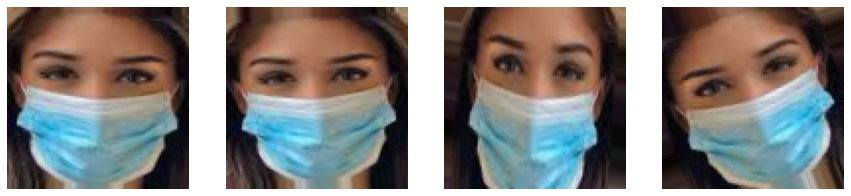

In [76]:
datagenerator = ImageDataGenerator(
        rotation_range=20,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

datagenerator.fit(train_data)

# Print sample of augmented image
image = load_img('data/trainvalidate/WithMask/148.png')
image_array = np.expand_dims(img_to_array(image), 0)
aug_iter = datagenerator.flow(image_array, batch_size=1)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
for i in range(4):
    image = next(aug_iter)[0].astype('uint8')
    ax[i].imshow(image)
    ax[i].axis('off')

### Model 1: Build and train (2 Conv Layers)

In [77]:
model1=Sequential()
model1.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,img_channels)))
model1.add(layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu'))
model1.add(layers.MaxPooling2D(pool_size=(2,2)))
model1.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
model1.add(layers.MaxPooling2D(pool_size=(2,2)))
model1.add(layers.Flatten())
model1.add(layers.Dropout(rate=0.5))
model1.add(layers.Dense(units=128,activation='relu'))
model1.add(layers.Dense(units=1,activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

history1 = model1.fit(datagenerator.flow(train_data, train_label,batch_size=batch_size), 
                    epochs=epochs, steps_per_epoch=len(train_data) / batch_size, 
                    validation_data=(valid_data,valid_label), validation_steps=len(valid_data) / batch_size)

# Get the weights used in the model
weights = []
for layer in model1.layers:
    weights.append(layer.get_weights())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_13 (Rescaling)     (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 50, 50, 64)        9280      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 40000)             0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 40000)           

### Model 2: Build and train (3 Conv Layers)

In [78]:
model2=Sequential()
model2.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))
model2.add(layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(rate=0.5))
model2.add(layers.Dense(units=128,activation='relu'))
model2.add(layers.Dense(units=1,activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

history2 = model2.fit(datagenerator.flow(train_data, train_label,batch_size=batch_size), 
                    epochs=epochs, steps_per_epoch=len(train_data) / batch_size, 
                    validation_data=(valid_data,valid_label), validation_steps=len(valid_data) / batch_size)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_14 (Rescaling)     (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 12, 12, 64)      

### Model 3: Build and train (4 Conv Layers)

In [79]:
model3=Sequential()
model3.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))
model3.add(layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu'))
model3.add(layers.MaxPooling2D(pool_size=(2,2)))
model3.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'))
model3.add(layers.MaxPooling2D(pool_size=(2,2)))
model3.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
model3.add(layers.MaxPooling2D(pool_size=(2,2)))
model3.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
model3.add(layers.MaxPooling2D(pool_size=(2,2)))
model3.add(layers.Flatten())
model3.add(layers.Dropout(rate=0.5))
model3.add(layers.Dense(units=128,activation='relu'))
model3.add(layers.Dense(units=1,activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model3.summary()

history3 = model3.fit(datagenerator.flow(train_data, train_label,batch_size=batch_size), 
                    epochs=epochs, steps_per_epoch=len(train_data) / batch_size, 
                    validation_data=(valid_data,valid_label), validation_steps=len(valid_data) / batch_size)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_15 (Rescaling)     (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 12, 12, 64)      

### Model 4: Build and train (4 Conv Layers)

In [80]:
model4=Sequential()
model4.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))
model4.add(layers.Conv2D(filters=16,kernel_size=(3,3),padding='same'))
model4.add(layers.MaxPooling2D(pool_size=(2,2)))
model4.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding='same'))
model4.add(layers.MaxPooling2D(pool_size=(2,2)))
model4.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding='same'))
model4.add(layers.MaxPooling2D(pool_size=(2,2)))
model4.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding='same'))
model4.add(layers.MaxPooling2D(pool_size=(2,2)))
model4.add(layers.Flatten())
model4.add(layers.Dropout(rate=0.5))
model4.add(layers.Dense(units=128,activation='relu'))
model4.add(layers.Dense(units=1,activation='sigmoid'))

model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model4.summary()

history4 = model4.fit(datagenerator.flow(train_data, train_label,batch_size=batch_size), 
                    epochs=epochs, steps_per_epoch=len(train_data) / batch_size, 
                    validation_data=(valid_data,valid_label), validation_steps=len(valid_data) / batch_size)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_16 (Rescaling)     (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 12, 12, 64)      

### Plot Model Training and Validation Accuracy and Loss

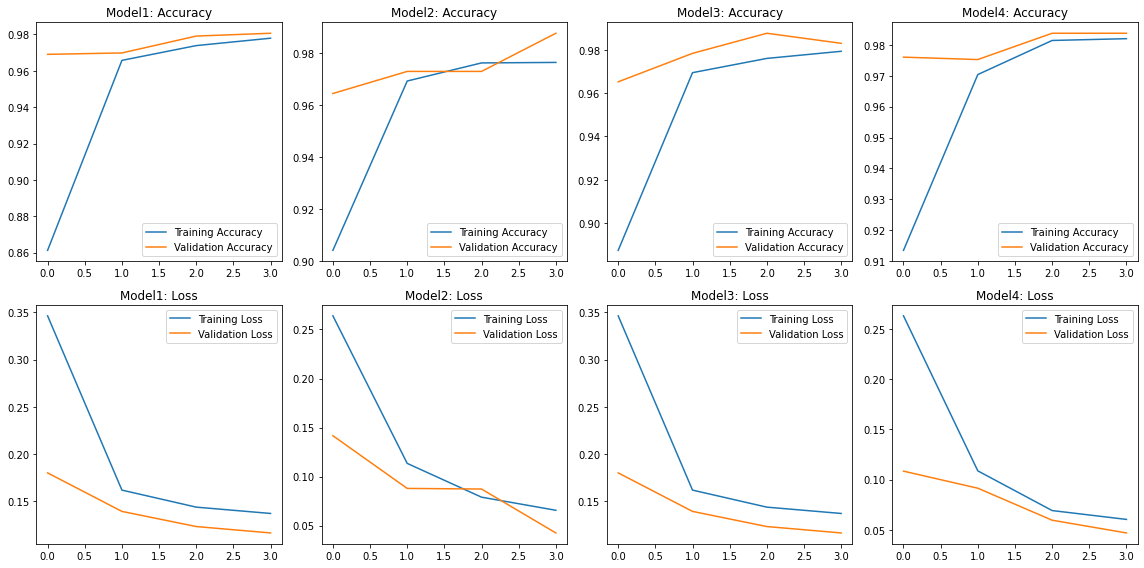

In [81]:
acc1 = history1.history['accuracy']
acc2 = history2.history['accuracy']
acc3 = history3.history['accuracy']
acc4 = history4.history['accuracy']

val_acc1 = history1.history['val_accuracy']
val_acc2 = history2.history['val_accuracy']
val_acc3 = history3.history['val_accuracy']
val_acc4 = history4.history['val_accuracy']

loss1 = history1.history['loss']
loss2 = history2.history['loss']
loss3 = history3.history['loss']
loss4 = history4.history['loss']

val_loss1 = history1.history['val_loss']
val_loss2 = history2.history['val_loss']
val_loss3 = history3.history['val_loss']
val_loss4 = history4.history['val_loss']

epochs_range = range(epochs)

fig, axs = plt.subplots(2, 4, constrained_layout=False, figsize=(16, 8))

axs[0,0].set_title('Model1: Accuracy')
axs[0,0].plot(epochs_range, acc1, label='Training Accuracy')
axs[0,0].plot(epochs_range, val_acc1, label='Validation Accuracy')
axs[0,0].legend(loc='lower right')

axs[0,1].set_title('Model2: Accuracy')
axs[0,1].plot(epochs_range, acc2, label='Training Accuracy')
axs[0,1].plot(epochs_range, val_acc2, label='Validation Accuracy')
axs[0,1].legend(loc='lower right')

axs[0,2].set_title('Model3: Accuracy')
axs[0,2].plot(epochs_range, acc3, label='Training Accuracy')
axs[0,2].plot(epochs_range, val_acc3, label='Validation Accuracy')
axs[0,2].legend(loc='lower right')

axs[0,3].set_title('Model4: Accuracy')
axs[0,3].plot(epochs_range, acc4, label='Training Accuracy')
axs[0,3].plot(epochs_range, val_acc4, label='Validation Accuracy')
axs[0,3].legend(loc='lower right')

axs[1,0].set_title('Model1: Loss')
axs[1,0].plot(epochs_range, loss1, label='Training Loss')
axs[1,0].plot(epochs_range, val_loss1, label='Validation Loss')
axs[1,0].legend(loc='upper right')

axs[1,1].set_title('Model2: Loss')
axs[1,1].plot(epochs_range, loss2, label='Training Loss')
axs[1,1].plot(epochs_range, val_loss2, label='Validation Loss')
axs[1,1].legend(loc='upper right')

axs[1,2].set_title('Model3: Loss')
axs[1,2].plot(epochs_range, loss1, label='Training Loss')
axs[1,2].plot(epochs_range, val_loss1, label='Validation Loss')
axs[1,2].legend(loc='upper right')

axs[1,3].set_title('Model4: Loss')
axs[1,3].plot(epochs_range, loss4, label='Training Loss')
axs[1,3].plot(epochs_range, val_loss4, label='Validation Loss')
axs[1,3].legend(loc='upper right')

fig.tight_layout()

### Test the models

In [82]:
# Perform tests
score1, acc1 = model1.evaluate(test_data, test_label, batch_size=100)
score2, acc2 = model2.evaluate(test_data, test_label, batch_size=100)
score3, acc3 = model3.evaluate(test_data, test_label, batch_size=100)
score4, acc4 = model4.evaluate(test_data, test_label, batch_size=100)

# Print test results in table
tableheader = ["Model #", "Accuracy"]
tabledata = list()
format_row = "{:<15}" * (len(tableheader))
print(format_row.format(*tableheader))
tabledata.append(("Model 1", str(acc1)))
tabledata.append(("Model 2", str(acc2)))
tabledata.append(("Model 3", str(acc3)))
tabledata.append(("Model 4", str(acc4)))
for row in tabledata:
    print(format_row.format(*row))

4/4 [==============================] - 1s 194ms/step - loss: 0.0204 - accuracy: 0.9971
Model #        Accuracy       
Model 1        0.9882698059082031
Model 2        0.9882698059082031
Model 3        0.9765396118164062
Model 4        0.9970674514770508


### Test random images of multiple people

Found 3 faces as follows: 1 wearing a mask, 2 not wearing a mask.


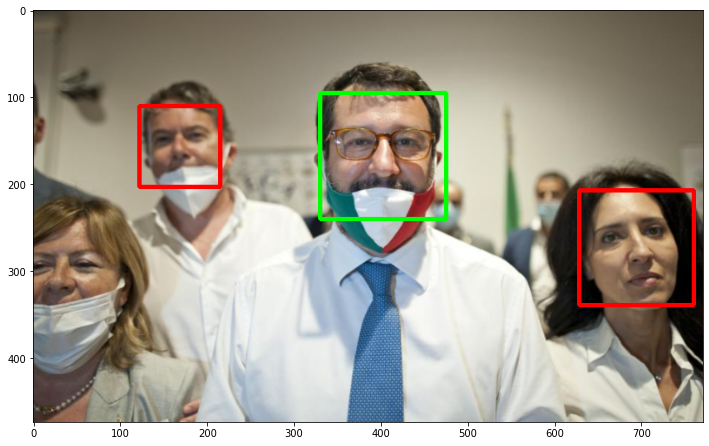

In [86]:
# Set image location
imagePath = "data/test/4.png"

# Create the haar cascade classifier
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

# Read the image
image = cv2.imread(imagePath)
b,g,r = cv2.split(image)       # get b, g, r
image = cv2.merge([r,g,b])     # switch to r, g, b
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect all the face coordinates in the image
faces_coords = faceCascade.detectMultiScale(
    #gray,
    image,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(10, 10),
    #flags = cv2.cv.CV_HAAR_SCALE_IMAGE
)

# retrieve each face then place in new array
faces = []
for (x, y, w, h) in faces_coords:
    faces.append(image[y:y+h, x:x+w])
    #cv2.imshow("Faces found", face)
    #cv2.waitKey(0)

# iterate over each face in the photo and check if it has a mask on, then store result in new array
mask_counter = no_mask_counter = 0
mask_location = []
for num, face in enumerate(faces):
    img1=cv2.resize(face,(img_height, img_width),interpolation=cv2.INTER_CUBIC)
    result = model3.predict(np.array([img1]))
    if result > 0.5:
        mask_counter += 1
        mask_location.append(num)
    else:
        no_mask_counter += 1

# iterate over each face then draw a rectangle around it, red if no mask, green if with mask
for num, (x, y, w, h) in enumerate(faces_coords):
    if num in mask_location:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 3)
    else:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 3)

print(f"Found {len(faces)} faces as follows: {mask_counter} wearing a mask, {no_mask_counter} not wearing a mask.")
plt.imshow(image)